In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
import scipy

import sys

sys.path.insert(0, '..')

### ---- ###
from functions.adjust_cases_functions import prepare_cases
from global_config import config


dict_map = {'10-10': (0,19), '10-19': (10, 19), '20-39': (20,39), '40-49': (40,49),
            '50-59': (50,59), '60-69': (60,69), '70-90+': (70,200) }

NGroups  = len(dict_map)

def age_group(val, dict_map):
    for ag in dict_map:
        if dict_map[ag][0] <= val <= dict_map[ag][1]:
            return ag
    return 'NaN'

data_dir      = config.get_property('data_dir_covid')
data_dir_mnps = config.get_property('data_dir_col')
results_dir   = config.get_property('results_dir')

location_folder = 'colombia'
agglomeration_method = 'geometry'
type_run = 'all'


In [7]:


# Agglomerated folder location
agglomerated_folder = os.path.join(data_dir, 'data_stages', location_folder, 'agglomerated', agglomeration_method )

raw_folder          = os.path.join(data_dir, 'data_stages', location_folder, 'raw' , 'cases')

poly_agg_path  = os.path.join(data_dir_mnps, 'administrative_division_col_2018.csv' )
poly_agg_df    = pd.read_csv(poly_agg_path, sep =',').set_index('poly_id')


cases_df_all = pd.read_csv(os.path.join(agglomerated_folder, 'cases.csv'), parse_dates =['date_time']).set_index('poly_id')
cases_df = cases_df_all.copy()

#poly_id2location = cases_df.copy().reset_index().groupby(['poly_id', 'location']).sum().reset_index()[['poly_id', 'location']].set_index('poly_id')

cases_raw_df = pd.read_csv(os.path.join(raw_folder, 'cases_raw.csv'), parse_dates =['Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de muerte'], dayfirst=True) #.set_index('poly_id')
cases_raw_df['age_group'] = cases_raw_df['Edad'].apply(lambda x: age_group( x, dict_map) )
cases_raw_df = cases_raw_df[['Código DIVIPOLA municipio', 'Nombre municipio', 'Nombre departamento',  'age_group', 'Sexo' ,'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de muerte']]
cases_raw_df = cases_raw_df.rename(columns={'Código DIVIPOLA municipio': 'poly_id'})

#poly_id2location = cases_raw_df.copy().reset_index().groupby(['poly_id','Nombre municipio', 'Nombre departamento']).sum().reset_index().set_index('poly_id')
#poly_id2location['location'] = poly_id2location.apply(lambda x: x['Nombre municipio'].lower()+'-'+x['Nombre departamento'].lower(), axis=1).reset_index()

list_df_ages = []
for age_g in dict_map.keys():
    cases_agei = cases_raw_df[cases_raw_df.age_group==age_g].copy()
    cases_agei['num_cases']    = 1
    cases_agei['num_diseased'] = 1
    cases_agei_num_cases  = cases_agei.copy().groupby(['Fecha de diagnóstico','poly_id']).sum().reset_index().rename(columns={'Fecha de diagnóstico': 'date_time'})[['date_time','poly_id','num_cases']]
    cases_agei_num_deaths = cases_agei.copy()[['Fecha de muerte','poly_id','num_diseased']].dropna().groupby(['Fecha de muerte','poly_id']).sum().reset_index().rename(columns={'Fecha de muerte': 'date_time'})
    new_df = pd.merge(cases_agei_num_cases, cases_agei_num_deaths,  how='outer').fillna(0)
    new_df = new_df.groupby(['date_time','poly_id']).sum().reset_index().set_index('poly_id')
    new_df['age_group'] = age_g
    list_df_ages.append(new_df)

cases_df_agg = cases_df.reset_index()[['poly_id','date_time', 'num_cases', 'num_diseased']]
cases_df_agg['age_group'] = 'agg'
list_df_ages.append(cases_df_agg.set_index('poly_id'))
df_cases_ages = pd.concat(list_df_ages)

poly_df  = pd.read_csv(os.path.join(agglomerated_folder, 'polygons.csv')).set_index('poly_id')

## add time delta
df_polygons = pd.read_csv( os.path.join( agglomerated_folder ,  "polygons.csv") )

# Time delay between FIS and diagnosis date
poly_df   = pd.read_csv( os.path.join( agglomerated_folder ,  "polygons.csv") ).set_index('poly_id')
pop_df = poly_df.copy()[['attr_area', 'geometry', 'attr_population']]

poly_df = poly_df.dropna(subset=['attr_time-delay_dist_mix', 'attr_time_death-delay_dist_mix'], axis='rows')

poly_df["attr_time-delay_dist_mix"] = poly_df["attr_time-delay_dist_mix"].fillna("")
poly_df = poly_df.dropna(subset=['attr_time-delay_dist_mix'], axis=0)
poly_df["attr_time_diag_delay"] = poly_df.apply(lambda x: np.fromstring(x["attr_time-delay_dist_mix"], sep="|"), axis=1)
poly_df = poly_df[poly_df['attr_time_diag_delay'].map(lambda x: len(x)) > 0]
poly_df = poly_df[poly_df['attr_time_diag_delay'].map(lambda x: ~np.isnan(list(x)[0] ))]


poly_df["attr_time_death-delay_dist_mix"] = poly_df["attr_time_death-delay_dist_mix"].fillna("")
poly_df["attr_time_death_delay"]          = poly_df.apply(lambda x: np.fromstring(x["attr_time_death-delay_dist_mix"], sep="|"), axis=1)
poly_df = poly_df.dropna(subset=['attr_time_death-delay_dist_mix'], axis=0)
poly_df["attr_time_death_delay"] = poly_df.apply(lambda x: np.fromstring(x["attr_time_death-delay_dist_mix"], sep="|"), axis=1)
poly_df = poly_df[poly_df['attr_time_death_delay'].map(lambda x: len(x)) > 0]
poly_df = poly_df[poly_df['attr_time_death_delay'].map(lambda x: ~np.isnan(list(x)[0] ))]

agg_p_delay_diag  = pd.DataFrame(list(poly_df['attr_time_diag_delay'])).mean().to_numpy()
agg_p_delay_diag[0] = 0

agg_p_delay_death = pd.DataFrame(list(poly_df['attr_time_death_delay'])).mean().to_numpy()
agg_p_delay_death[0] = 0

def crosscorr(cases, deaths, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return deaths.corr(cases.shift(lag))


def compute_correlation(cases, deaths, lags = list(range(41)), start_day='01-04-2020', final_day=None):

    if not start_day:
        start_day = min(cases.index.values[0], deaths.index.values[0])
    if not final_day:
        final_day = min(cases.index.values[-1], deaths.index.values[-1])

    min_date = pd.to_datetime(start_day, dayfirst=True)
    max_date = pd.to_datetime(final_day, dayfirst=True)

    cases = cases.loc[start_day:max_date]
    deaths = deaths.loc[start_day:max_date]

    corr_df = pd.DataFrame(columns = ['lag', 'value'])
    corr_df['lag'] = lags
    corr_df = corr_df.set_index('lag')

    for idx, lag in enumerate(lags):
        corr_df.loc[lag]['value'] = crosscorr(cases, deaths, lag=lag)

    return corr_df


def cfr(cases, deaths, lag, start_day='01-04-2020', final_day=None):

    if not start_day:
        start_day = min(cases.index.values[0], deaths.index.values[0])
    if not final_day:
        final_day = min(cases.index.values[-1], deaths.index.values[-1])

    #start_day = '01-04-2020'
    #final_day = '31-10-2020'

    min_date = pd.to_datetime(start_day, dayfirst=True)
    max_date = pd.to_datetime(final_day, dayfirst=True)

    min_init = min(cases.index.values[0], deaths.index.values[0])
    min_date = min(min_date, min_init)

    max_init = min(cases.index.values[-1], deaths.index.values[-1])
    max_date = min(max_date, max_init)


    cases = cases.loc[min_date:max_date]
    deaths = deaths.loc[min_date:max_date]

    cfr = pd.DataFrame(columns = ['date_time', 'value'])

    #cfr['date_time'] = pd.date_range(start=min_date, end=max_date, freq='D')
    #cfr['value']     = deaths.shift(lag).values / cases.values

    return deaths.shift(lag).values / cases.values

cases_df['state']    = cases_df.apply(lambda x: x['location'].split('-')[-1], axis=1)
state2id = {}
for state_id in cases_df['state'].unique():
    poly_id = str(cases_df.reset_index().set_index("state").loc[state_id]['poly_id'].iloc[0])
    if len(poly_id)==4: #==state_id")['poly_id'].iloc[0])==4:
        state2id[state_id] = '0'+poly_id[:1]
    else:
        state2id[state_id] = poly_id[:2]

def get_location_state(poly_id, cases_df_all):
    try:
        location = cases_df_all.loc[poly_id]['location'].iloc[0]
    except:
        return 'None'

    return (location.split('-')[0], location.split('-')[1])

from tqdm import tqdm
poly_info = {}
for idx, poly_id in tqdm(enumerate(cases_df.reset_index()['poly_id'].unique())):

    # If polygon not in polygons use aggregated p_delay
    if poly_id in poly_df.index.values:
        p_delay_diag = poly_df.loc[poly_id]["attr_time_diag_delay"]
    else:
        p_delay_diag = agg_p_delay_diag

    if poly_id in poly_df.index.values:
        p_delay_death = poly_df.loc[poly_id]["attr_time_death_delay"]
    else:
        p_delay_death = agg_p_delay_death

    try:
        list_cases_df = []
        for age_group in df_cases_ages.age_group.unique():
            cases_df = df_cases_ages[df_cases_ages.age_group==age_group]
            cases  = cases_df.loc[poly_id][['date_time','num_cases']].set_index('date_time').resample('D').sum().fillna(0)[['num_cases']]
            cases  = prepare_cases(cases, col='num_cases', cutoff=0)
            cases['age_group'] = age_group
            list_cases_df.append(cases)
        cases = pd.concat(list_cases_df)

    except:
        continue

    list_deaths_df = []
    for age_group in df_cases_ages.age_group.unique():
        deaths_df = df_cases_ages[df_cases_ages.age_group==age_group]
        deaths  = deaths_df.loc[poly_id][['date_time','num_diseased']].set_index('date_time').resample('D').sum().fillna(0)[['num_diseased']]
        deaths['age_group'] = age_group
        list_deaths_df.append(deaths)
    deaths = pd.concat(list_deaths_df)



    if deaths[deaths.age_group=='agg']['num_diseased'].sum() <= 100:
        continue
    start_date = deaths[deaths.age_group=='agg'].index.values[np.where(deaths[deaths.age_group=='agg']['num_diseased'].cumsum()>=1)[0][0]] + pd.Timedelta(days=8)
    #df_corr_poly_id = compute_correlation(cases_onset['num_cases'], deaths['num_diseased'], lags = list(range(41)), start_day=start_date, final_day='31-10-2020')

    poly_info[poly_id] = {
                    'poly_id'         : poly_id,
                    'poly_name'       : get_location_state(poly_id, cases_df_all)[0],
                    'state'           : get_location_state(poly_id, cases_df_all)[1],
                    'population'      : pop_df.loc[poly_id]['attr_population'],
                    'area'            : pop_df.loc[poly_id]['attr_area'],
                    'delay_diag'      : p_delay_diag,
                    'delay_death'     : p_delay_death,
                    'geometry'        : pop_df.loc[poly_id]['geometry']
                    }
    # TODO: add                key 'corr_lag'        : df_corr_poly_id
    path_to_save = os.path.join( results_dir, 'colombia', 'cfr')

    for age_group in deaths.age_group.unique():
        cases_ag = cases[cases.age_group==age_group][['num_cases', 'smoothed_num_cases']]
    
        poly_info[poly_id]['cases_diag_{}'.format(age_group)]  = cases_ag
        poly_info[poly_id]['cases_onset_{}'.format(age_group)] = confirmed_to_onset(cases_ag['smoothed_num_cases'], p_delay_diag, 'num_cases')
        poly_info[poly_id]['deaths_{}'.format(age_group)]      = deaths[deaths.age_group==age_group][['num_diseased']]

/Users/chaosdonkey06/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (14,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
1102it [06:01,  3.05it/s]


,geometry,num_cases,num_diseased,attr_population,poly_name,state_name,mun_name
poly_id,,,,,,,
70001,POLYGON ((-7272157.312192403 1204552.358262144...,14673.0,502.0,286716.0,Sincelejo-Sucre,Sucre,Sincelejo
70110,POLYGON ((-7216108.480420387 1207534.552583118...,317.0,5.0,9746.0,Buenavista-Sucre,Sucre,Buenavista
70124,POLYGON ((-7242289.534977318 1141204.618482083...,109.0,3.0,12419.0,Caimito-Sucre,Sucre,Caimito
70204,POLYGON ((-7259553.750855568 1231859.609727063...,34.0,3.0,5731.0,Coloso-Sucre,Sucre,Coloso
70215,MULTIPOLYGON (((-7249811.003665372 1195355.595...,1817.0,72.0,63657.0,Corozal-Sucre,Sucre,Corozal
70221,POLYGON ((-7280959.166897879 1210197.028111116...,662.0,11.0,14288.0,Coveñas-Sucre,Sucre,Coveñas
70230,POLYGON ((-7256853.750376928 1232823.821804388...,28.0,2.0,4401.0,Chalán-Sucre,Sucre,Chalán
70233,POLYGON ((-7235987.167897837 1171029.231595433...,67.0,5.0,10917.0,El Roble-Sucre,Sucre,El Roble
70235,POLYGON ((-7217698.137871399 1177786.863155015...,206.0,8.0,21199.0,Galeras-Sucre,Sucre,Galeras


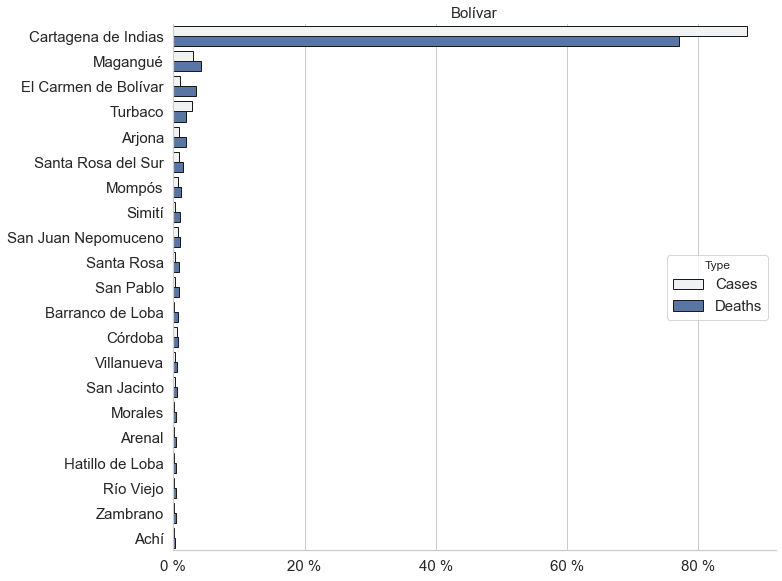

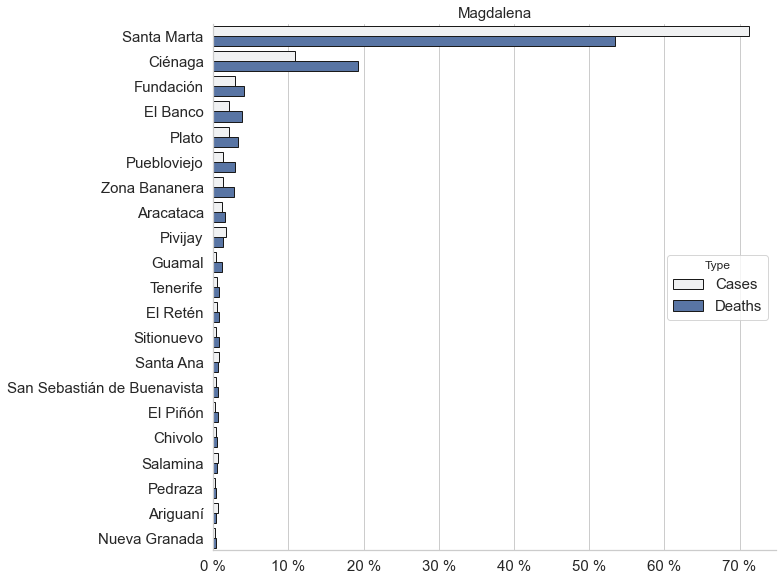

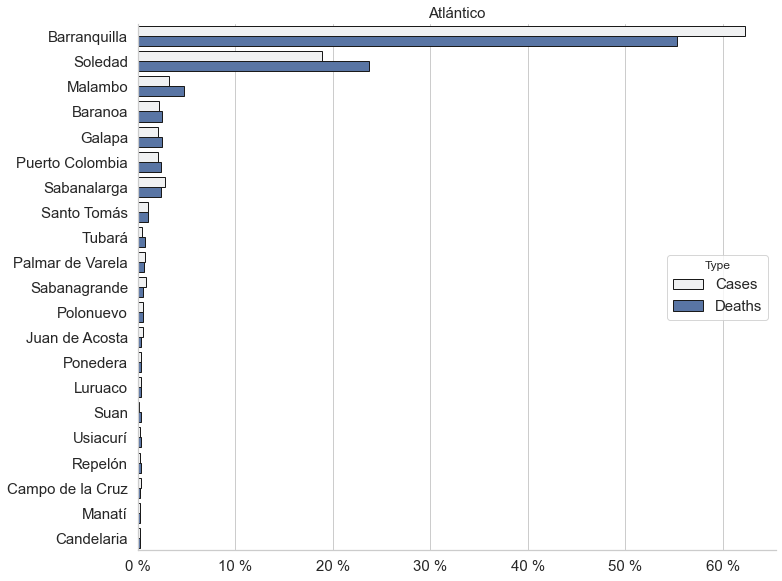

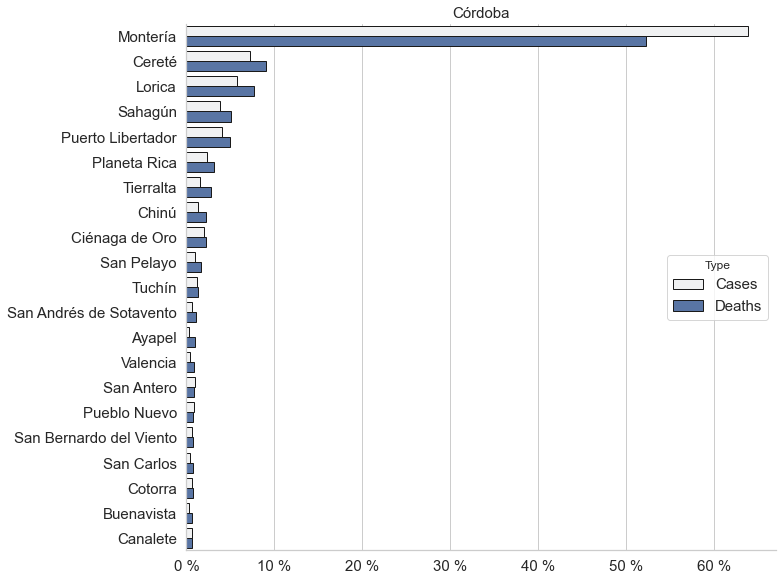

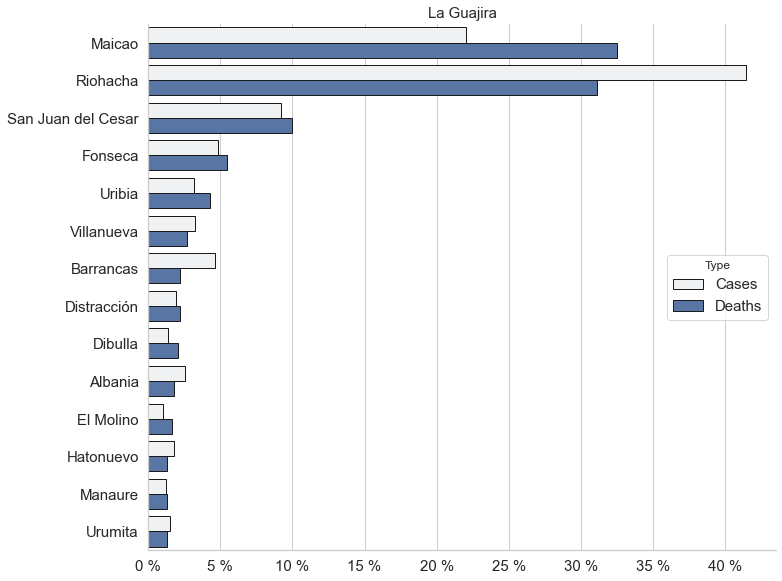

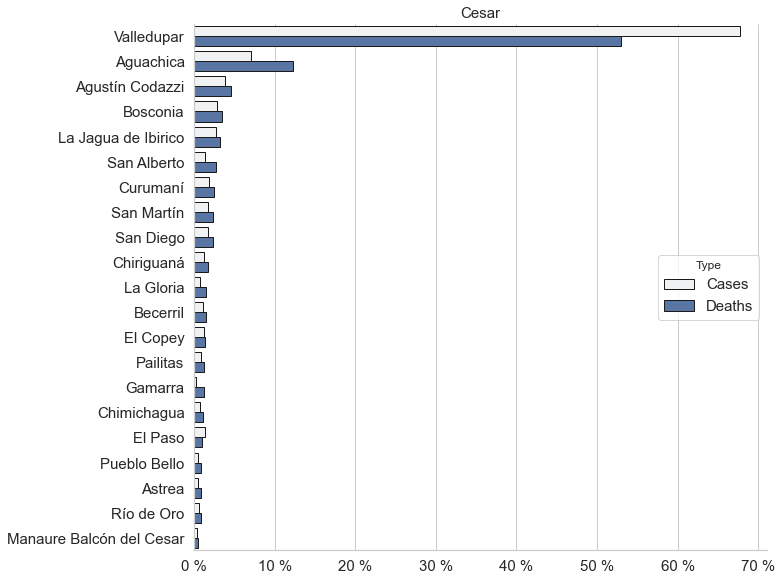

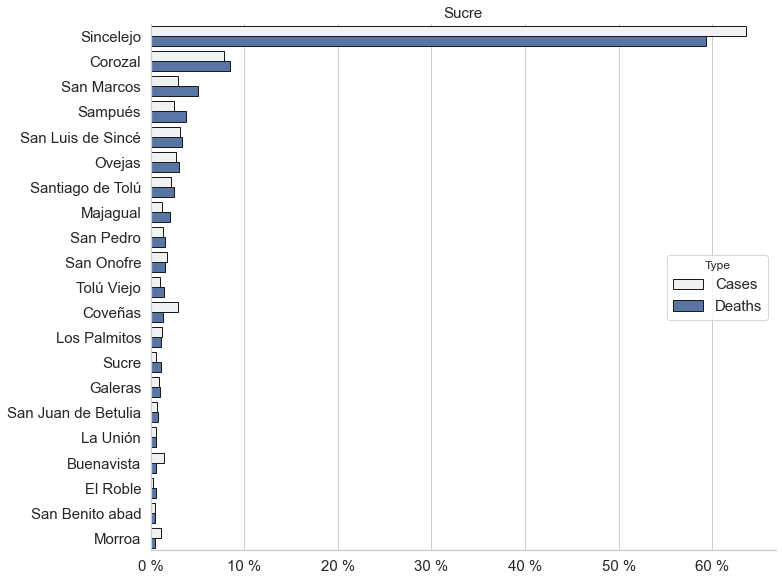

In [160]:
import seaborn as sns
sns.set_color_codes("pastel")
sns.set_theme(style="whitegrid")


state_df = poly_df.copy(); state_df = state_df[["geometry", "num_cases", "num_diseased", "attr_population", "poly_name"]]
state_df["state_name"] = state_df.apply(lambda x: x.poly_name.split('-')[-1], axis=1)
state_df["mun_name"] = state_df.apply(lambda x: x.poly_name.split('-')[0], axis=1)


# Costa

def plot_incident_prop(incident_df, title, path_to_save=None):
    incident_df  = incident_df.sort_values(by='num_diseased', ascending=False)
    incident_df  = incident_df.iloc[:21]
    frac         = np.concatenate((100 * incident_df["num_cases"].values / incident_df["num_cases"].sum(), 100 * incident_df["num_diseased"].values / incident_df["num_diseased"].sum())  )

    incident_df = pd.concat([incident_df, incident_df])
    incident_df['frac']  = frac
    incident_df['type']  = ['Cases']* (len(incident_df)//2) + ['Deaths']*(len(incident_df)//2)

    ax = sns.catplot(x="frac", y="mun_name", hue='type', data=incident_df,  edgecolor='k', color="b", kind='bar', height=8, aspect=5/4)
    sns.despine(top=True, right=True)
    ax.legend.set_visible(False)
    ax.axes[0][0].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f} %"))
    ax.axes[0][0].tick_params(axis='both', labelsize=15)
    ax.axes[0][0].set_ylabel(None)
    ax.axes[0][0].set_xlabel(None)
    ax.axes[0][0].legend(loc="center right", frameon=True, title='Type', fontsize=15)
    plt.tight_layout()
    
    if title:
        plt.title(title, fontsize=15)

    if path_to_save:
        ax.fig.savefig(path_to_save,  dpi=300,  bbox_inches='tight', transparent=True)

list_state   = ['Bolívar', 'Magdalena' ,'Atlántico' , 'Córdoba' , 'La Guajira' , 'Cesar' , 'Sucre']

for st in list_state:
    ss_df = state_df[state_df.state_name==st].sort_values(by='num_diseased', ascending=False)
    
    plot_incident_prop(ss_df, title=st, path_to_save=None)
    plt.show()

- Cartagena de Indias-Bolívar 13001
- Santa Marta-Magdalena 47001
- Barranquilla-Atlántico 8001
- Montería-Córdoba 23001
- Maicao-La Guajira 44430
- Valledupar-Cesar 20001
- Sincelejo-Sucre 70001

In [171]:
!python3 ../estimate.py 13001 cartagena True
!python3 ../create_files.py 11001 bogota True

**** Running inference and forecast for cartagena
**** **** Last day uploaded 2021-Apr-03
**** **** *** Droping last 2wk
**** **** **** Fitting until 2021-Mar-20
sample: 100%|█| 2400/2400 [1:25:11<00:00,  2.13s/it, 511 steps of size 8.59e-03.

                            mean       std    median      5.0%     95.0%     n_eff     r_hat
                    D0      0.62      0.68      0.40      0.00      1.46   2878.11      1.00
                    E0     14.39      8.18     13.99      0.41     26.49    344.25      1.00
                    H0      0.57      0.56      0.41      0.00      1.27   2998.70      1.00
                    I0      8.51      9.05      6.00      0.00     18.21    189.78      1.00
                 beta0      0.95      0.41      0.91      0.28      1.51      9.50      1.03
  confirmed_dispersion      0.10      0.00      0.10      0.10      0.11   2513.46      1.00
      death_dispersion      0.10      0.00      0.10      0.10      0.10   2402.82      1.00
            

         det_prob[158]      0.81      0.11      0.82      0.65      0.98    148.85      1.00
         det_prob[159]      0.81      0.11      0.83      0.66      0.98    145.90      1.00
         det_prob[160]      0.81      0.11      0.83      0.65      0.98    142.21      1.00
         det_prob[161]      0.82      0.10      0.84      0.67      0.98    143.00      1.00
         det_prob[162]      0.82      0.10      0.84      0.68      0.98    142.77      1.00
         det_prob[163]      0.83      0.10      0.85      0.69      0.98    142.96      1.00
         det_prob[164]      0.84      0.09      0.85      0.71      0.98    148.47      1.00
         det_prob[165]      0.84      0.09      0.86      0.72      0.98    142.30      1.00
         det_prob[166]      0.85      0.09      0.86      0.72      0.98    142.09      1.00
         det_prob[167]      0.85      0.09      0.86      0.72      0.98    138.63      1.00
         det_prob[168]      0.85      0.09      0.86      0.72      0.

Number of divergences: 9
 * collecting in-sample predictive samples
 * collecting forecast samples
** Creating Files


In [ ]:
!python3 ../create_files.py 13001 cartagena True

In [172]:
!python3 ../estimate.py 47001 st_marta True


**** Running inference and forecast for st_marta
**** **** Last day uploaded 2021-Apr-03
**** **** *** Droping last 2wk
**** **** **** Fitting until 2021-Mar-20
sample: 100%|█| 2400/2400 [53:59<00:00,  1.35s/it, 1023 steps of size 4.76e-03. 

                            mean       std    median      5.0%     95.0%     n_eff     r_hat
                    D0      0.62      0.66      0.40      0.00      1.47   3158.53      1.00
                    E0     14.84      8.20     14.59      1.56     27.80   1107.70      1.00
                    H0      0.65      0.65      0.45      0.00      1.49   2803.02      1.00
                    I0     11.45      9.83      8.76      0.19     24.38    316.98      1.00
                 beta0      0.84      0.28      0.80      0.40      1.22      6.71      1.26
  confirmed_dispersion      0.10      0.00      0.10      0.10      0.11   3253.38      1.00
      death_dispersion      0.10      0.00      0.10      0.10      0.11   3684.53      1.00
            d

Number of divergences: 0
 * collecting in-sample predictive samples
 * collecting forecast samples
** Creating Files


In [173]:
!python3 ../estimate.py 8001 barranquilla True
!python3 ../create_files.py 8001 barranquilla True

**** Running inference and forecast for barranquilla
**** **** Last day uploaded 2021-Apr-03
**** **** *** Droping last 2wk
**** **** **** Fitting until 2021-Mar-20
sample: 100%|█| 2400/2400 [7:26:36<00:00, 11.17s/it, 1023 steps of size 4.39e-03

                            mean       std    median      5.0%     95.0%     n_eff     r_hat
                    D0      0.62      0.66      0.41      0.00      1.49   2180.63      1.00
                    E0     15.72      8.13     16.02      3.38     29.46    224.00      1.01
                    H0      0.58      0.58      0.39      0.00      1.32   2084.40      1.00
                    I0     11.51     10.36      8.82      0.15     24.91    149.30      1.00
                 beta0      0.63      0.30      0.59      0.19      1.06      5.09      1.22
  confirmed_dispersion      0.10      0.00      0.10      0.10      0.10   2209.66      1.00
      death_dispersion      0.10      0.00      0.10      0.10      0.10   1536.17      1.00
         

Number of divergences: 286
 * collecting in-sample predictive samples
 * collecting forecast samples
** Creating Files


In [ ]:
!python3 ../estimate.py 23001 monteria True
!python3 ../create_files.py 23001 monteria True

**** Running inference and forecast for monteria
**** **** Last day uploaded 2021-Apr-04
**** **** *** Droping last 2wk
**** **** **** Fitting until 2021-Mar-21
sample:  19%|▏| 459/2400 [09:30<46:54,  1.45s/it, 1023 steps of size 3.91e-03. a

In [ ]:
!python3 ../estimate.py 44430 maicao True
!python3 ../create_files.py 44430 maicao True

In [ ]:
!python3 ../estimate.py 20001 valledupar True
!python3 ../create_files.py 20001 valledupar True

In [ ]:
!python3 ../estimate.py 70001 sincelejo True
!python3 ../create_files.py 70001 sincelejo True